## BDA557 Store based sales forecasting on a fast fashion retailer

Importing the packages that we needed

In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

color_pallet = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import warnings
import seaborn as sns
import matplotlib.pyplot as plt



from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
# Disable all warnings
warnings.filterwarnings("ignore")

# Your code goes here, and all warnings will not be displayed

# If you want to enable warnings again:
# warnings.filterwarnings("default")

# Data implementation

In [160]:
dosya_ismi =  "forecast_data_2.csv"
arama_kok_dizini = "/"

for klasor_yolu, alt_klasorler, dosyalar in os.walk(arama_kok_dizini):
    if dosya_ismi in dosyalar:
        dosya_yolu = os.path.join(klasor_yolu, dosya_ismi)
        print("Dosya bulundu:", dosya_yolu)
        break
else:
    print("Dosya bulunamadı.")


Dosya bulundu: /Users\mustafa.tilkat\Downloads\forecast_data_2.csv


In [161]:
data = pd.read_csv(dosya_yolu)

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265 entries, 0 to 7264
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Store_ID   7265 non-null   int64  
 1   Date_time  7265 non-null   object 
 2   Sales      6765 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 170.4+ KB


Date format needs to be fixed from object to datetime

In [163]:
data['Date_time'] = pd.to_datetime(data['Date_time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265 entries, 0 to 7264
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Store_ID   7265 non-null   int64         
 1   Date_time  7265 non-null   datetime64[ns]
 2   Sales      6765 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 170.4 KB


# EDA

In [164]:
data.head(5)

,Store_ID,Date_time,Sales
0,1,2021-06-01,1307.0
1,2,2021-06-01,1083.0
2,3,2021-06-01,NaN
3,4,2021-06-01,996.0
4,5,2021-06-01,1642.0


In [165]:
data.tail(5)

,Store_ID,Date_time,Sales
7260,6,2023-06-01,2314.0
7261,7,2023-06-01,1566.0
7262,8,2023-06-01,604.0
7263,9,2023-06-01,741.0
7264,10,2023-06-01,1226.0


In [166]:
data.describe()

,Store_ID,Sales
count,7265.000000,6765.000000
mean,5.497454,1193.777531
std,2.871519,827.698753
min,1.000000,2.000000
25%,3.000000,580.000000
50%,5.000000,954.000000
75%,8.000000,1576.000000
max,10.000000,7732.000000


In [167]:
data.describe(percentiles=[0.8,0.6,0.4,0.2])

,Store_ID,Sales
count,7265.000000,6765.000000
mean,5.497454,1193.777531
std,2.871519,827.698753
min,1.000000,2.000000
20%,2.000000,520.000000
40%,4.000000,791.000000
50%,5.000000,954.000000
60%,6.000000,1146.000000
80%,8.000000,1783.000000
max,10.000000,7732.000000


# Checking NaN values

In [168]:
num_nan_colums = data.isna().sum(axis=0)

print("Number of NaN Values in each column:")
print(num_nan_colums)

Number of NaN Values in each column:
Store_ID       0
Date_time      0
Sales        500
dtype: int64


Because of having NaN data we need to fix this issue at next steps

In [169]:
num_nan_rows = data.isna().sum(axis=1)

print("Number of NaN Values in each Row:")
print(num_nan_rows)

Number of NaN Values in each Row:
0       0
1       0
2       1
3       0
4       0
       ..
7260    0
7261    0
7262    0
7263    0
7264    0
Length: 7265, dtype: int64


In [170]:
data[data.isna().any(axis=1) | data.isnull().any(axis=1)]

,Store_ID,Date_time,Sales
2,3,2021-06-01,NaN
42,3,2021-06-05,NaN
44,5,2021-06-05,NaN
47,8,2021-06-05,NaN
48,9,2021-06-05,NaN
...,...,...,...
7159,5,2023-05-22,NaN
7167,3,2023-05-23,NaN
7229,5,2023-05-29,NaN
7243,9,2023-05-30,NaN


# Data Manupilation

NaN values will be filled as the average sales of last 4 weeks at each day of week

First, we need to add day of week with using dayofweek function

In [171]:
data['dayofweek'] = data['Date_time'].dt.dayofweek
data

,Store_ID,Date_time,Sales,dayofweek
0,1,2021-06-01,1307.0,1
1,2,2021-06-01,1083.0,1
2,3,2021-06-01,NaN,1
3,4,2021-06-01,996.0,1
4,5,2021-06-01,1642.0,1
...,...,...,...,...
7260,6,2023-06-01,2314.0,3
7261,7,2023-06-01,1566.0,3
7262,8,2023-06-01,604.0,3
7263,9,2023-06-01,741.0,3


In [172]:
# Setting the date time interval of the last 4 weeks at each store
end_date = data['Date_time'].max()
start_date = end_date - pd.DateOffset(weeks=4)

# Filtering the data of the last 4 weeks
filtered_df = data[(data['Date_time'] >= start_date) & (data['Date_time'] <= end_date)]

# Calculating the average sales grouping by store and day
result_df = filtered_df.groupby(['Store_ID', 'dayofweek'])['Sales'].mean().reset_index()
result_df

,Store_ID,dayofweek,Sales
0,1,0,758.00
1,1,1,779.50
2,1,2,769.25
3,1,3,769.20
4,1,4,732.00
...,...,...,...
65,10,2,1229.00
66,10,3,1156.20
67,10,4,1404.00
68,10,5,1961.75


In [173]:
#  as you can see filtered NaN values seen like at below
condition = (data['Store_ID'] == 1) & (data['dayofweek'] == 4) &  (data['Sales'].apply(np.isnan))
data.loc[condition]

,Store_ID,Date_time,Sales,dayofweek
150,1,2021-06-18,NaN,4
270,1,2021-07-02,NaN,4
1669,1,2021-11-19,NaN,4
2019,1,2021-12-24,NaN,4
2509,1,2022-02-11,NaN,4
3698,1,2022-06-10,NaN,4
4747,1,2022-09-23,NaN,4
5517,1,2022-12-09,NaN,4
7125,1,2023-05-19,NaN,4


In [174]:
check_indexes = data.loc[condition, 'Sales'].index.tolist()
check_indexes

[150, 270, 1669, 2019, 2509, 3698, 4747, 5517, 7125]

In [175]:
for index, row in result_df.iterrows():
    store_id = row['Store_ID']
    dayofweek = row['dayofweek']
    avg_sales = row['Sales']
    
    condition = (data['Store_ID'] == store_id) & (data['dayofweek'] == dayofweek) &  (data['Sales'].apply(np.isnan))
    data.loc[condition, 'Sales'] = data.loc[condition, 'Sales'].fillna(avg_sales)


In [176]:
condition = (result_df['Store_ID'] == 1) & (result_df['dayofweek'] == 4)
result_df.loc[condition]

,Store_ID,dayofweek,Sales
4,1,4,732.0


As it can be seen, the values we have filled with the values in the selected date range, fits with the values we have calculated. The function we set up checks all the stores one by one and finds the average value of the last 4 weeks of that store and fills. 

In [177]:
data.iloc[check_indexes]

,Store_ID,Date_time,Sales,dayofweek
150,1,2021-06-18,732.0,4
270,1,2021-07-02,732.0,4
1669,1,2021-11-19,732.0,4
2019,1,2021-12-24,732.0,4
2509,1,2022-02-11,732.0,4
3698,1,2022-06-10,732.0,4
4747,1,2022-09-23,732.0,4
5517,1,2022-12-09,732.0,4
7125,1,2023-05-19,732.0,4


In [178]:
data.drop(['dayofweek'], axis = 1 ,inplace = True)

As we can see from the data each store has different statistics.

In [179]:
data.groupby(["Store_ID"]).agg({"Sales": ["count","sum", "mean", "median", "std", "min", "max"]})

Sales                                                               
         count           sum         mean  median          std    min     max
Store_ID                                                                     
1          727  6.817311e+05   937.731843   826.0   461.774291  313.0  3670.0
2          727  4.298575e+05   591.275791   497.0   347.694341  135.0  2736.0
3          727  6.068503e+05   834.732233   704.0   477.838953  229.0  3723.0
4          727  5.172071e+05   711.426547   613.0   372.379226  174.0  2927.0
5          727  7.380868e+05  1015.250046   911.0   530.245025  270.0  4301.0
6          726  1.543869e+06  2126.540909  2022.0  1002.190970    2.0  7732.0
7          727  1.580663e+06  2174.227579  2170.0   730.257958  430.0  4412.0
8          727  5.015326e+05   689.866025   622.0   311.613555  202.0  2209.0
9          727  8.626434e+05  1186.579711  1094.0   562.963862    5.0  3971.0
10         723  1.124041e+06  1554.689557  1403.0   752.202299   45.0  6065.0

When we check the autocorrelation function for Store1,  we can see that some days have a strong relationship with our independent variable.

<Figure size 1500x500 with 0 Axes>

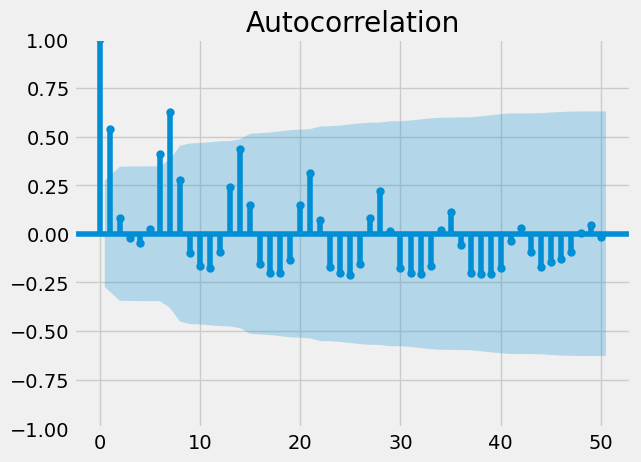

In [180]:
store_1 = data[data['Store_ID'] == 1].set_index('Date_time')
lag_acf = acf(store_1['Sales'], nlags=50)

# Image creation
fig = plt.figure(figsize=(15, 5))
plot_acf(lag_acf, lags=50)

plt.show()

Trends shows that we have a seasonality trend not only for one store but also at our complete data set.

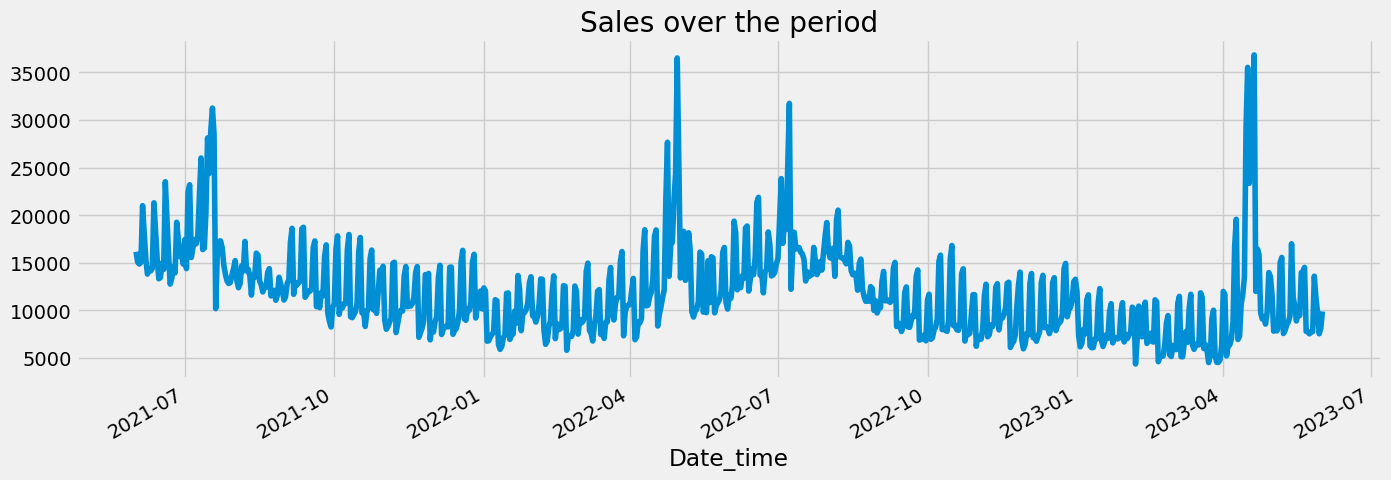

In [181]:
data.groupby(['Date_time'])['Sales'].sum().plot(
        # style='.',
        figsize=(15, 5),
        color=color_pallet[0],
        title='Sales over the period')
plt.show()

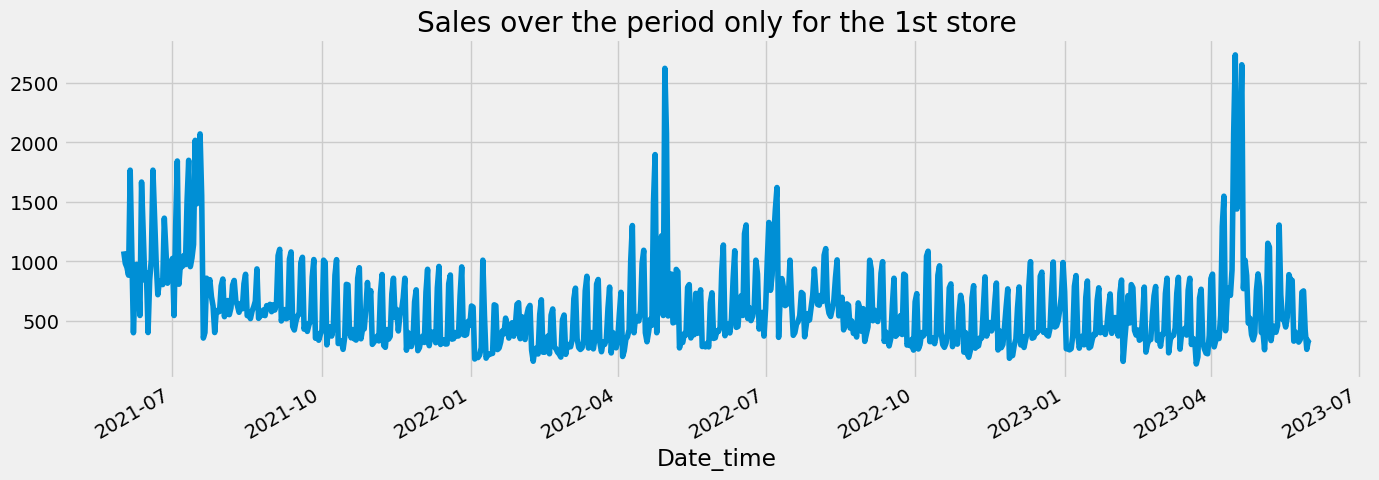

In [182]:
data[(data['Store_ID']==2)].groupby(['Date_time'])['Sales'].sum().plot(
        # style='.',
        figsize=(15, 5),
        color=color_pallet[0],
        title='Sales over the period only for the 1st store')
plt.show()

As an idea, clustring before starting model building and selection part would be a useful however we have a limited dataset for this workhop it is not applied.

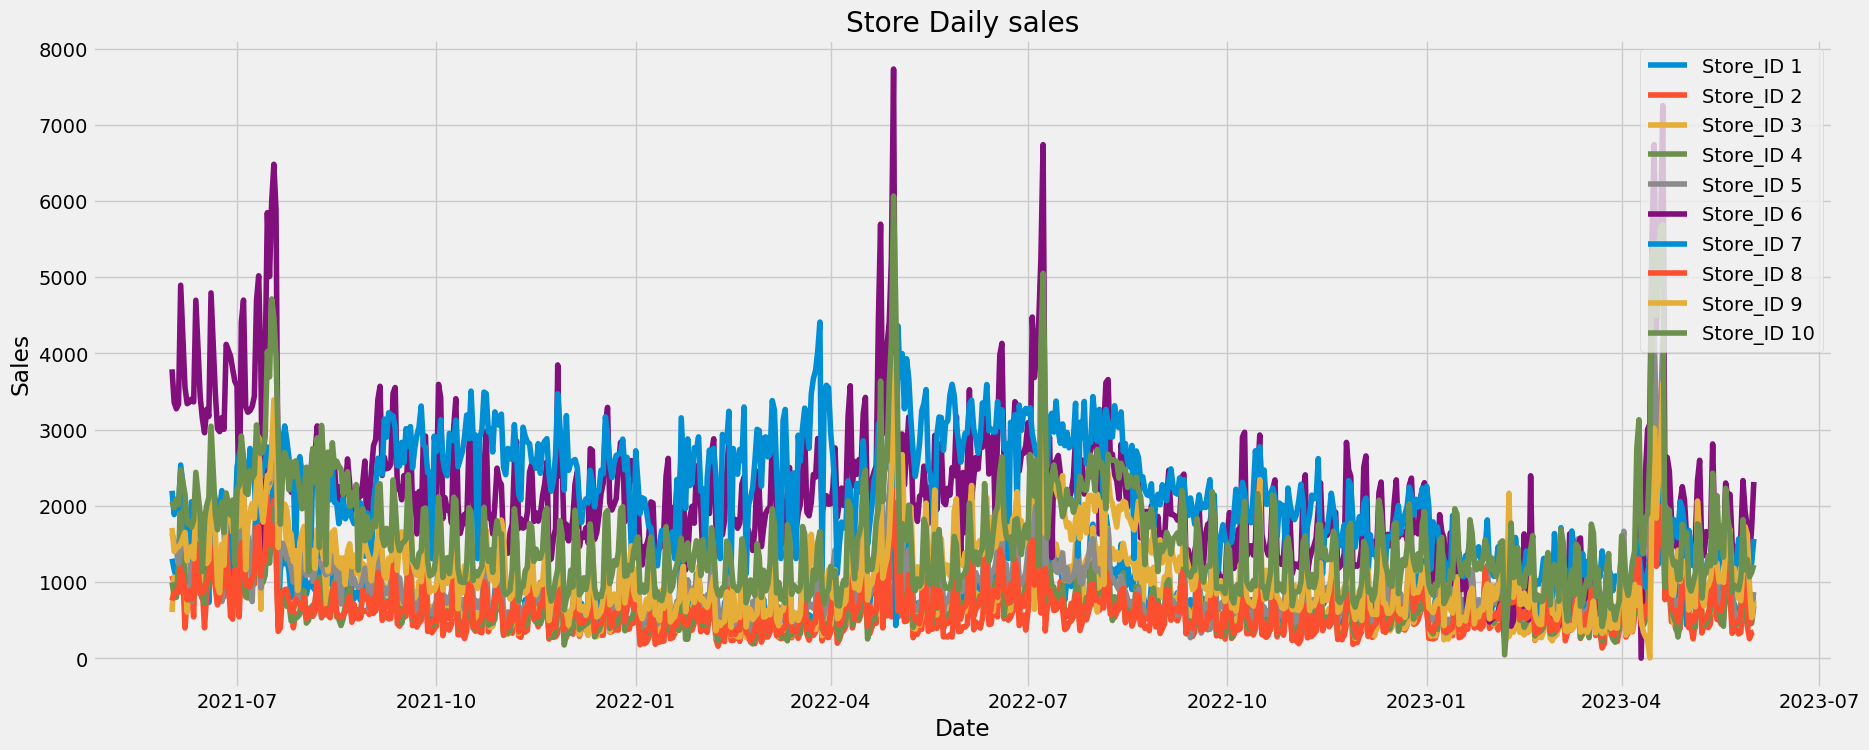

In [183]:
store_daily_sales = data.groupby(['Store_ID', 'Date_time'], as_index=False)['Sales'].sum()
plt.figure(figsize=(20, 8))

for i in range(1, 11):
    temp = store_daily_sales[store_daily_sales['Store_ID'] == i]
    plt.plot(temp['Date_time'].to_numpy(), temp['Sales'].to_numpy(), label='Store_ID %d' % i)

plt.legend()
plt.title('Store Daily sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [184]:
def create_date_time_features(df):

    df = df.copy()
    #df['hour'] = df.index.hour
    df['dayofweek'] = df.Date_time.dt.dayofweek
    df['quarter'] = df.Date_time.dt.quarter
    df['month'] = df.Date_time.dt.month
    df['year'] = df.Date_time.dt.year
    df['dayofyear'] = df.Date_time.dt.dayofyear
    df['dayofmonth'] = df.Date_time.dt.day
    df['weekofyear'] = df.Date_time.dt.isocalendar().week.astype("int64")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([3,4,5]), 1, df["season"])
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    df['is_month_start'] = (df.Date_time.dt.is_month_start).astype(int)
    df['is_month_end'] = (df.Date_time.dt.is_month_end).astype(int)
    return df

In [185]:
df1= create_date_time_features(data)
df1

,Store_ID,Date_time,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,is_month_start,is_month_end
0,1,2021-06-01,1307.000000,1,2,6,2021,152,1,22,2,1,0
1,2,2021-06-01,1083.000000,1,2,6,2021,152,1,22,2,1,0
2,3,2021-06-01,605.666667,1,2,6,2021,152,1,22,2,1,0
3,4,2021-06-01,996.000000,1,2,6,2021,152,1,22,2,1,0
4,5,2021-06-01,1642.000000,1,2,6,2021,152,1,22,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7260,6,2023-06-01,2314.000000,3,2,6,2023,152,1,22,2,1,0
7261,7,2023-06-01,1566.000000,3,2,6,2023,152,1,22,2,1,0
7262,8,2023-06-01,604.000000,3,2,6,2023,152,1,22,2,1,0
7263,9,2023-06-01,741.000000,3,2,6,2023,152,1,22,2,1,0


## We can perform more advanced descriptive analysis:

In [186]:
df1.groupby(["Store_ID", "year", "month"]).agg({"Sales": ["sum", "mean", "median", "std"]})

Sales                                  
                          sum         mean  median          std
Store_ID year month                                            
1        2021 6      31822.00  1223.923077  1142.5   330.367998
              7      44432.20  1433.296774  1318.0   562.356314
              8      30855.00   995.322581   979.0   153.314358
              9      25727.00   857.566667   747.5   335.092852
              10     23937.25   772.169355   618.0   305.130610
...                       ...          ...     ...          ...
10       2023 2      29473.50  1091.611111  1080.0   355.267622
              3      30523.70   984.635484   910.0   381.467367
              4      69707.25  2323.575000  1598.0  1618.840452
              5      41874.00  1350.774194  1214.0   436.857468
              6       1226.00  1226.000000  1226.0          NaN

[250 rows x 4 columns]

In [187]:
df1.groupby(["Store_ID", "year", "month","dayofmonth"]).agg({"Sales": ["sum", "mean", "median"]})

Sales                
                                   sum    mean  median
Store_ID year month dayofmonth                        
1        2021 6     1           1307.0  1307.0  1307.0
                    2           1165.0  1165.0  1165.0
                    3           1062.0  1062.0  1062.0
                    4           1048.0  1048.0  1048.0
                    5           1951.0  1951.0  1951.0
...                                ...     ...     ...
10       2023 5     28          1160.0  1160.0  1160.0
                    29          1295.0  1295.0  1295.0
                    30          1070.0  1070.0  1070.0
                    31          1128.0  1128.0  1128.0
              6     1           1226.0  1226.0  1226.0

[7265 rows x 3 columns]

# Training and Test Split visualization

In [188]:
data['Date_time'].max()

Timestamp('2023-06-01 00:00:00')

In [189]:
data['Date_time'].min()

Timestamp('2021-06-01 00:00:00')

With the relativedelta function of the dateutil.relativedelta library, we determine the datetimes we will fit our train and test data.

In [190]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# last 3 months data
start_date= data['Date_time'].max()
end_date = data['Date_time'].max() + relativedelta(months=-3)

print("start_date :",end_date)
print("end_date :",  data['Date_time'].max())




start_date : 2023-03-01 00:00:00
end_date : 2023-06-01 00:00:00


In [191]:
df2 = df1.copy()

# Training and Test Split visualization

In [192]:
df2

,Store_ID,Date_time,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,is_month_start,is_month_end
0,1,2021-06-01,1307.000000,1,2,6,2021,152,1,22,2,1,0
1,2,2021-06-01,1083.000000,1,2,6,2021,152,1,22,2,1,0
2,3,2021-06-01,605.666667,1,2,6,2021,152,1,22,2,1,0
3,4,2021-06-01,996.000000,1,2,6,2021,152,1,22,2,1,0
4,5,2021-06-01,1642.000000,1,2,6,2021,152,1,22,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7260,6,2023-06-01,2314.000000,3,2,6,2023,152,1,22,2,1,0
7261,7,2023-06-01,1566.000000,3,2,6,2023,152,1,22,2,1,0
7262,8,2023-06-01,604.000000,3,2,6,2023,152,1,22,2,1,0
7263,9,2023-06-01,741.000000,3,2,6,2023,152,1,22,2,1,0


In [193]:
train = df1.loc[df1['Date_time'] < start_date]
test = df1.loc[df1['Date_time'] >= start_date]

In [194]:
train

,Store_ID,Date_time,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,is_month_start,is_month_end
0,1,2021-06-01,1307.000000,1,2,6,2021,152,1,22,2,1,0
1,2,2021-06-01,1083.000000,1,2,6,2021,152,1,22,2,1,0
2,3,2021-06-01,605.666667,1,2,6,2021,152,1,22,2,1,0
3,4,2021-06-01,996.000000,1,2,6,2021,152,1,22,2,1,0
4,5,2021-06-01,1642.000000,1,2,6,2021,152,1,22,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7250,6,2023-05-31,1720.000000,2,2,5,2023,151,31,22,1,0,1
7251,7,2023-05-31,1248.000000,2,2,5,2023,151,31,22,1,0,1
7252,8,2023-05-31,629.000000,2,2,5,2023,151,31,22,1,0,1
7253,9,2023-05-31,533.000000,2,2,5,2023,151,31,22,1,0,1


In [195]:
test

,Store_ID,Date_time,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,is_month_start,is_month_end
7255,1,2023-06-01,758.0,3,2,6,2023,152,1,22,2,1,0
7256,2,2023-06-01,344.0,3,2,6,2023,152,1,22,2,1,0
7257,3,2023-06-01,762.0,3,2,6,2023,152,1,22,2,1,0
7258,4,2023-06-01,692.0,3,2,6,2023,152,1,22,2,1,0
7259,5,2023-06-01,870.0,3,2,6,2023,152,1,22,2,1,0
7260,6,2023-06-01,2314.0,3,2,6,2023,152,1,22,2,1,0
7261,7,2023-06-01,1566.0,3,2,6,2023,152,1,22,2,1,0
7262,8,2023-06-01,604.0,3,2,6,2023,152,1,22,2,1,0
7263,9,2023-06-01,741.0,3,2,6,2023,152,1,22,2,1,0
7264,10,2023-06-01,1226.0,3,2,6,2023,152,1,22,2,1,0


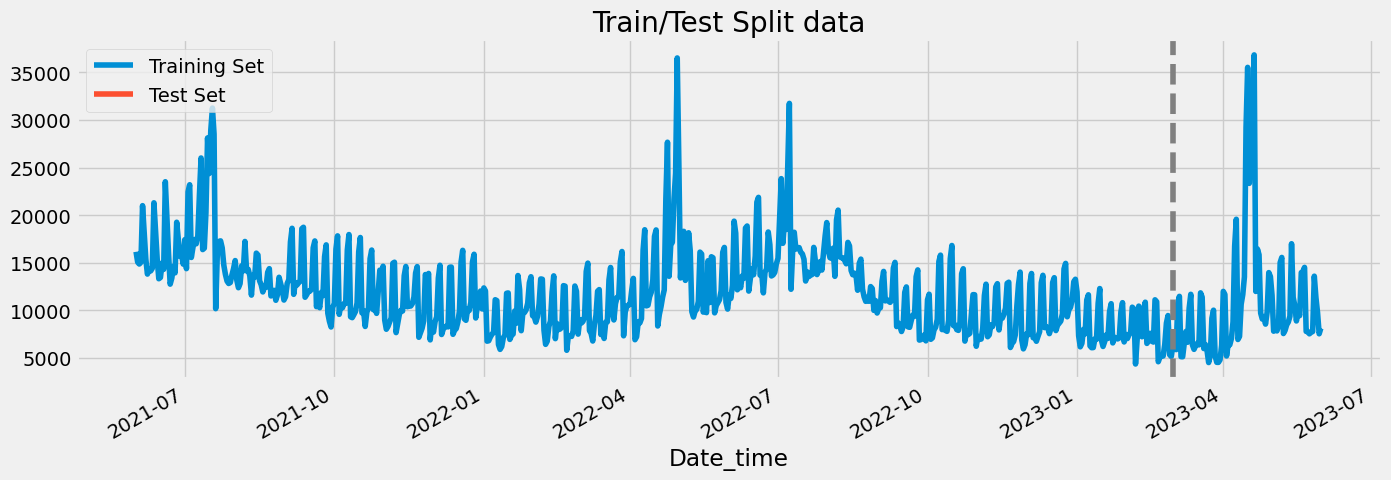

In [196]:
fig, ax = plt.subplots(figsize=(15, 5))
train.groupby(['Date_time'])['Sales'].sum().plot(ax=ax, label='Training Set', title='Train/Test Split data')
test.groupby(['Date_time'])['Sales'].sum().plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
ax.axvline('2023-03-01', color='Gray', ls='--')

plt.show()

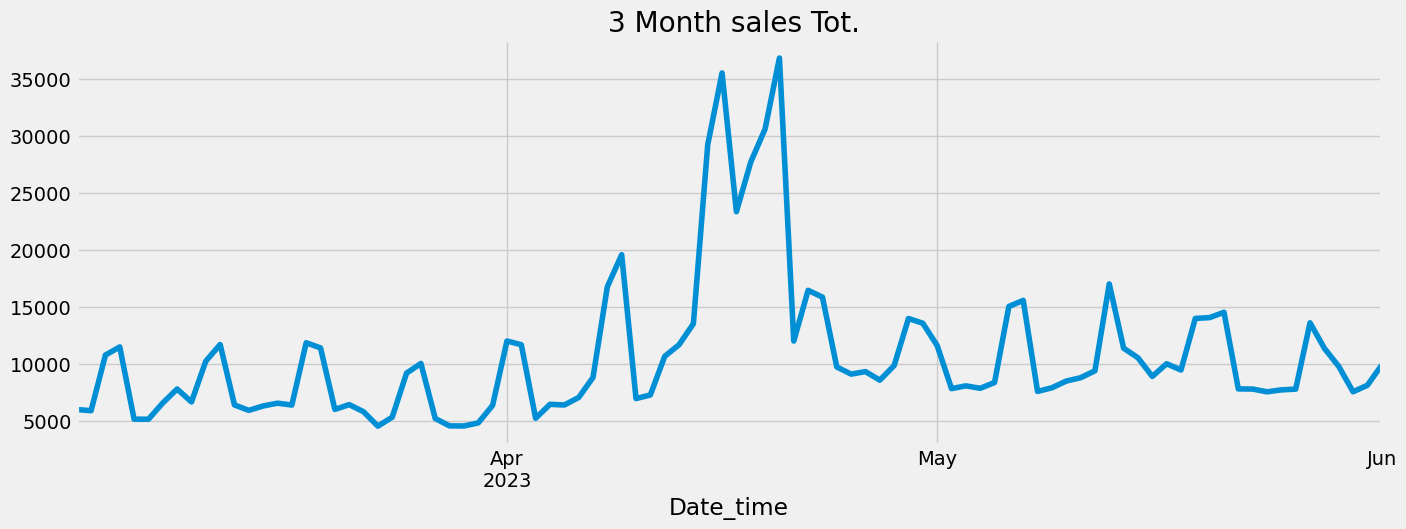

In [197]:
df1.loc[(df1['Date_time'] > '2023-03-01') & (df1['Date_time'] <= '2023-06-01')].groupby(['Date_time'])['Sales'].sum() \
    .plot(figsize=(15, 5), title=' 3 Month sales Tot.')
plt.show()

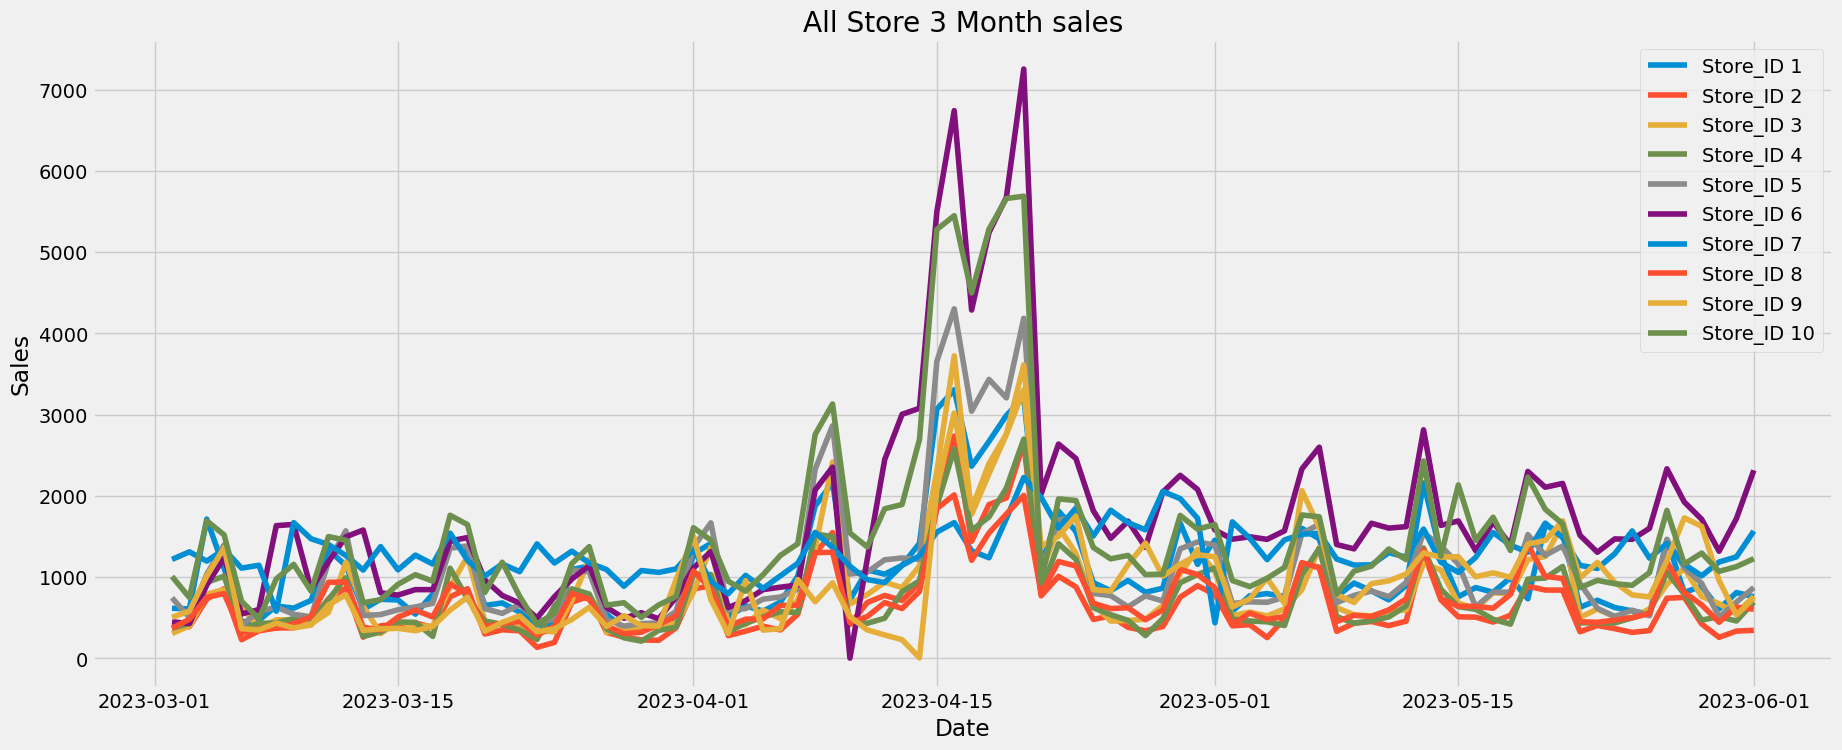

In [198]:
store_daily_sales = df1.loc[(df1['Date_time'] > '2023-03-01') & (df1['Date_time'] <= '2023-06-01')].groupby(['Store_ID', 'Date_time'], as_index=False)['Sales'].sum()
plt.figure(figsize=(20, 8))

for i in range(1, 11):
    temp = store_daily_sales[store_daily_sales['Store_ID'] == i]
    plt.plot(temp['Date_time'].to_numpy(), temp['Sales'].to_numpy(), label='Store_ID %d' % i)

plt.legend()
plt.title('All Store 3 Month sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

## Splitting Train and Test AND One-Hot-Encoding

In [199]:
df2.columns.tolist()

['Store_ID',
 'Date_time',
 'Sales',
 'dayofweek',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'season',
 'is_month_start',
 'is_month_end']

In [200]:
df2

,Store_ID,Date_time,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,is_month_start,is_month_end
0,1,2021-06-01,1307.000000,1,2,6,2021,152,1,22,2,1,0
1,2,2021-06-01,1083.000000,1,2,6,2021,152,1,22,2,1,0
2,3,2021-06-01,605.666667,1,2,6,2021,152,1,22,2,1,0
3,4,2021-06-01,996.000000,1,2,6,2021,152,1,22,2,1,0
4,5,2021-06-01,1642.000000,1,2,6,2021,152,1,22,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7260,6,2023-06-01,2314.000000,3,2,6,2023,152,1,22,2,1,0
7261,7,2023-06-01,1566.000000,3,2,6,2023,152,1,22,2,1,0
7262,8,2023-06-01,604.000000,3,2,6,2023,152,1,22,2,1,0
7263,9,2023-06-01,741.000000,3,2,6,2023,152,1,22,2,1,0


We define a function that uses a simple for loop to create the lag features, this function will take the list of lag days I have specified and use the panda shift() function to shift our data for the given number of days for the number of days in these values.

In [201]:
def create_lag(df, lag_list):
    for lag in lag_list:
        lag_colum_name = str('lag_' + str(lag))
        df[lag_colum_name] = df.groupby(["Store_ID"])['Sales'].transform(lambda x: x.shift(lag))
    return df

In [202]:
df2= create_lag(df2, [1,7, 91, 182, 364, 546])

In [206]:
df2

,Store_ID,Date_time,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,is_month_start,is_month_end,lag_1,lag_7,lag_91,lag_182,lag_364,lag_546
0,1,2021-06-01,1307.000000,1,2,6,2021,152,1,22,2,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2021-06-01,1083.000000,1,2,6,2021,152,1,22,2,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2021-06-01,605.666667,1,2,6,2021,152,1,22,2,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2021-06-01,996.000000,1,2,6,2021,152,1,22,2,1,0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2021-06-01,1642.000000,1,2,6,2021,152,1,22,2,1,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7260,6,2023-06-01,2314.000000,3,2,6,2023,152,1,22,2,1,0,1720.0,1464.0,419.0,1208.0,2438.0,1541.0
7261,7,2023-06-01,1566.000000,3,2,6,2023,152,1,22,2,1,0,1248.0,1567.0,1217.0,1858.0,2951.0,2563.0
7262,8,2023-06-01,604.000000,3,2,6,2023,152,1,22,2,1,0,629.0,501.0,369.0,319.0,676.0,592.8
7263,9,2023-06-01,741.000000,3,2,6,2023,152,1,22,2,1,0,533.0,780.0,504.0,891.2,1381.0,628.0


## We can see the lag values we created and how the shift() function works.

In [208]:
df2.groupby(["Store_ID",'Date_time']).mean().reset_index().head(15)

,Store_ID,Date_time,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,is_month_start,is_month_end,lag_1,lag_7,lag_91,lag_182,lag_364,lag_546
0,1,2021-06-01,1307.0,1.0,2.0,6.0,2021.0,152.0,1.0,22.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-06-02,1165.0,2.0,2.0,6.0,2021.0,153.0,2.0,22.0,2.0,0.0,0.0,1307.0,NaN,NaN,NaN,NaN,NaN
2,1,2021-06-03,1062.0,3.0,2.0,6.0,2021.0,154.0,3.0,22.0,2.0,0.0,0.0,1165.0,NaN,NaN,NaN,NaN,NaN
3,1,2021-06-04,1048.0,4.0,2.0,6.0,2021.0,155.0,4.0,22.0,2.0,0.0,0.0,1062.0,NaN,NaN,NaN,NaN,NaN
4,1,2021-06-05,1951.0,5.0,2.0,6.0,2021.0,156.0,5.0,22.0,2.0,0.0,0.0,1048.0,NaN,NaN,NaN,NaN,NaN
5,1,2021-06-07,953.0,0.0,2.0,6.0,2021.0,158.0,7.0,23.0,2.0,0.0,0.0,1951.0,NaN,NaN,NaN,NaN,NaN
6,1,2021-06-08,1085.0,1.0,2.0,6.0,2021.0,159.0,8.0,23.0,2.0,0.0,0.0,953.0,NaN,NaN,NaN,NaN,NaN
7,1,2021-06-09,1161.0,2.0,2.0,6.0,2021.0,160.0,9.0,23.0,2.0,0.0,0.0,1085.0,1307.0,NaN,NaN,NaN,NaN
8,1,2021-06-10,1209.0,3.0,2.0,6.0,2021.0,161.0,10.0,23.0,2.0,0.0,0.0,1161.0,1165.0,NaN,NaN,NaN,NaN
9,1,2021-06-11,1073.0,4.0,2.0,6.0,2021.0,162.0,11.0,23.0,2.0,0.0,0.0,1209.0,1062.0,NaN,NaN,NaN,NaN


### This is our function below , One-Hot-Encoding separates the colums we will do by using list comprehantion 

In [209]:
list_1 = df2.columns.tolist()
print(f'first list : {list_1}')
removed_values = ['Date_time', 'Sales','is_month_start','is_month_end','Store_ID','lag_7', 'dayofyear', 'dayofmonth', 'weekofyear',
 'lag_91',
 'lag_182',
 'lag_364',
 'lag_546',
 'lag_1',]

filtered_list = [x for x in list_1 if x not in removed_values]

print(f'filtered_list : {filtered_list}')

first list : ['Store_ID', 'Date_time', 'Sales', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'season', 'is_month_start', 'is_month_end', 'lag_1', 'lag_7', 'lag_91', 'lag_182', 'lag_364', 'lag_546']
filtered_list : ['dayofweek', 'quarter', 'month', 'year', 'season']


### To implement One-Hot-Encoding we use the pd.get_dummies function of the pandas library

In [210]:
df3 = pd.get_dummies(df2, columns=filtered_list,dtype=int)
df3.shape

(7265, 44)

In [211]:
df3

,Store_ID,Date_time,Sales,dayofyear,dayofmonth,weekofyear,is_month_start,is_month_end,lag_1,lag_7,...,month_10,month_11,month_12,year_2021,year_2022,year_2023,season_0,season_1,season_2,season_3
0,1,2021-06-01,1307.000000,152,1,22,1,0,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
1,2,2021-06-01,1083.000000,152,1,22,1,0,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
2,3,2021-06-01,605.666667,152,1,22,1,0,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
3,4,2021-06-01,996.000000,152,1,22,1,0,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
4,5,2021-06-01,1642.000000,152,1,22,1,0,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7260,6,2023-06-01,2314.000000,152,1,22,1,0,1720.0,1464.0,...,0,0,0,0,0,1,0,0,1,0
7261,7,2023-06-01,1566.000000,152,1,22,1,0,1248.0,1567.0,...,0,0,0,0,0,1,0,0,1,0
7262,8,2023-06-01,604.000000,152,1,22,1,0,629.0,501.0,...,0,0,0,0,0,1,0,0,1,0
7263,9,2023-06-01,741.000000,152,1,22,1,0,533.0,780.0,...,0,0,0,0,0,1,0,0,1,0


In [212]:
df_model= df3.copy()
df_model = df_model.sort_values("Date_time").reset_index(drop = True)

In [213]:
train= df_model.loc[(df_model["Date_time"] < "2023-03-01"), :]

test = df_model.loc[(df_model["Date_time"] >= "2023-03-01") & (df_model["Date_time"] < "2023-06-01"), :]

In [214]:
train

,Store_ID,Date_time,Sales,dayofyear,dayofmonth,weekofyear,is_month_start,is_month_end,lag_1,lag_7,...,month_10,month_11,month_12,year_2021,year_2022,year_2023,season_0,season_1,season_2,season_3
0,1,2021-06-01,1307.000000,152,1,22,1,0,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
1,2,2021-06-01,1083.000000,152,1,22,1,0,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
2,3,2021-06-01,605.666667,152,1,22,1,0,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
3,4,2021-06-01,996.000000,152,1,22,1,0,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
4,5,2021-06-01,1642.000000,152,1,22,1,0,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,4,2023-02-28,317.000000,59,28,9,0,1,322.0,426.0,...,0,0,0,0,0,1,1,0,0,0
6332,3,2023-02-28,229.000000,59,28,9,0,1,266.0,282.0,...,0,0,0,0,0,1,1,0,0,0
6333,2,2023-02-28,354.000000,59,28,9,0,1,334.0,305.0,...,0,0,0,0,0,1,1,0,0,0
6334,1,2023-02-28,440.000000,59,28,9,0,1,534.0,533.0,...,0,0,0,0,0,1,1,0,0,0


In [215]:
test

,Store_ID,Date_time,Sales,dayofyear,dayofmonth,weekofyear,is_month_start,is_month_end,lag_1,lag_7,...,month_10,month_11,month_12,year_2021,year_2022,year_2023,season_0,season_1,season_2,season_3
6336,9,2023-03-01,581.0,60,1,9,1,0,591.0,445.0,...,0,0,0,0,0,1,0,1,0,0
6337,8,2023-03-01,504.0,60,1,9,1,0,399.0,369.0,...,0,0,0,0,0,1,0,1,0,0
6338,7,2023-03-01,1637.0,60,1,9,1,0,794.0,975.0,...,0,0,0,0,0,1,0,1,0,0
6339,6,2023-03-01,419.0,60,1,9,1,0,462.0,425.0,...,0,0,0,0,0,1,0,1,0,0
6340,10,2023-03-01,1229.0,60,1,9,1,0,1138.0,817.0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7250,4,2023-05-31,459.0,151,31,22,0,1,513.0,435.0,...,0,0,0,0,0,1,0,1,0,0
7251,3,2023-05-31,550.0,151,31,22,0,1,672.0,510.0,...,0,0,0,0,0,1,0,1,0,0
7252,2,2023-05-31,335.0,151,31,22,0,1,258.0,365.0,...,0,0,0,0,0,1,0,1,0,0
7253,1,2023-05-31,809.0,151,31,22,0,1,608.0,625.0,...,0,0,0,0,0,1,0,1,0,0


### Missing Values check For test and  train

In [216]:
print('There is {} missing values in train set'.format(train.isnull().values.sum()))
print('There is {} missing values in test set'.format(test.isnull().values.sum()))

There is 11910 missing values in train set
There is 0 missing values in test set


In [217]:
cols = [col for col in train.columns if col not in ['Date_time', "Sales",'Store_ID']]

In [218]:
X_train = train[cols]
Y_train = train[['Sales']]

X_test = test[cols]
Y_test = test[['Sales']]
store_ID_colum  = test['Store_ID']

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((6336, 41), (6336, 1), (919, 41), (919, 1))

In [219]:
X_train

,dayofyear,dayofmonth,weekofyear,is_month_start,is_month_end,lag_1,lag_7,lag_91,lag_182,lag_364,...,month_10,month_11,month_12,year_2021,year_2022,year_2023,season_0,season_1,season_2,season_3
0,152,1,22,1,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
1,152,1,22,1,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
2,152,1,22,1,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
3,152,1,22,1,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
4,152,1,22,1,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,59,28,9,0,1,322.0,426.0,277.0,756.000000,380.0,...,0,0,0,0,0,1,1,0,0,0
6332,59,28,9,0,1,266.0,282.0,261.0,899.000000,393.0,...,0,0,0,0,0,1,1,0,0,0
6333,59,28,9,0,1,334.0,305.0,209.0,601.000000,301.0,...,0,0,0,0,0,1,1,0,0,0
6334,59,28,9,0,1,534.0,533.0,485.0,763.000000,779.5,...,0,0,0,0,0,1,1,0,0,0


In [220]:
Y_train

,Sales
0,1307.000000
1,1083.000000
2,605.666667
3,996.000000
4,1642.000000
...,...
6331,317.000000
6332,229.000000
6333,354.000000
6334,440.000000


In [221]:
def rmse(y_test, y_pred):
    return(mse(y_test, y_pred)**0.5)
def model_results(y_test, y_pred,model_name: str):
    print('MSE score of model is {}'.format(mse(y_test, y_pred)))
    print('RMSE score of model is {}'.format(rmse(y_test, y_pred)))
    print('MAE score of model is {}'.format(mae(y_test, y_pred)))

    rmse_new = rmse(y_test, y_pred)
    mae_new =  mae(y_test, y_pred)
    
    xg_r2 = r2_score(y_test, y_pred)
    df = pd.DataFrame({'Model_name': [model_name],
                       'MAE': [mae_new],
                       'RMSE': [rmse_new],
                        'R2_score' : [xg_r2]})
    
    
    return df

# Use of Three Different Machine Learning (ML) models 

# Base Model of  RandomForest (RF)

In [222]:
regr = RandomForestRegressor(n_estimators=100, random_state=42,max_depth = 50,bootstrap =False)

In Rf we have to fill null values, so for this ML algorithm we fill null values with 0

In [223]:
X_train_rf = train[cols].fillna(0)
Y_train_rf = train[['Sales']].fillna(0)

X_test_rf = test[cols].fillna(0)
Y_test_rf = test[['Sales']].fillna(0)
store_ID_colum_rf  = test['Store_ID'].fillna(0)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((6336, 41), (6336, 1), (919, 41), (919, 1))

In [224]:
print('There is {} missing values in train set'.format(X_train_rf.isnull().values.sum()))
print('There is {} missing values in test set'.format(Y_train_rf.isnull().values.sum()))

There is 0 missing values in train set
There is 0 missing values in test set


In [225]:
regr.fit(X_train_rf, Y_train_rf)

RandomForestRegressor(bootstrap=False, max_depth=50, random_state=42)

In [226]:
#prediction
y_pred = regr.predict(X_test_rf )

In [227]:
def rmse(y_test, y_pred):
    return(mse(y_test, y_pred)**0.5)

In [228]:
model_results(Y_test_rf, y_pred,'RF')

MSE score of model is 408072.48297723284
RMSE score of model is 638.8055126384187
MAE score of model is 354.07578545520494


,Model_name,MAE,RMSE,R2_score
0,RF,354.075785,638.805513,0.380411


## Model Tuning of RandomForest

In [229]:
rf_params = {'max_depth': [10, 20, 30,40,50],
            'bootstrap': [True, False],
            'min_samples_split': [2,3,4,5,6, 7],
            'min_samples_leaf': [2, 3, 4, 5,6, 7],
            'max_features': ['auto']}

### Results of Best parameters of RF

In [230]:
rf_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'criterion': 'squared_error',
    'max_depth': 20,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 7,
    'min_samples_split': 6,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False
}


In [231]:
rf_model = RandomForestRegressor(**rf_params)

In [232]:
rf_model.fit(X_train_rf, Y_train_rf)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=6, n_jobs=-1, random_state=42)

In [233]:
y_pred = rf_model.predict(X_test)

In [234]:
model_results(Y_test_rf, y_pred, 'Rf')

MSE score of model is 323912.54975642613
RMSE score of model is 569.1331564374246
MAE score of model is 325.12311690204984


,Model_name,MAE,RMSE,R2_score
0,Rf,325.123117,569.133156,0.508194


In [235]:
df_rf= model_results(Y_test_rf, y_pred, 'Rf')

MSE score of model is 323912.54975642613
RMSE score of model is 569.1331564374246
MAE score of model is 325.12311690204984


# Base Model of  LGBMRegressor

In [236]:
print('There is {} missing values in train set'.format(X_train.isnull().values.sum()))
print('There is {} missing values in test set'.format(Y_train.isnull().values.sum()))

There is 11910 missing values in train set
There is 0 missing values in test set


In [237]:
# Create a LightGBM model
lgbm_model = LGBMRegressor()
eval_set = [(X_train, Y_train), (X_test, Y_test)]
eval_metric = 'rmse'


In [238]:
lgbmbase = lgbm_model.fit(X_train, Y_train, eval_set=eval_set, eval_metric=eval_metric)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1933
[LightGBM] [Info] Number of data points in the train set: 6336, number of used features: 41
[LightGBM] [Info] Start training from score 1198.833730


In [239]:
#prediction
y_pred = lgbmbase.predict(X_test)

In [240]:
model_results(Y_test, y_pred, 'LGBM')

MSE score of model is 236594.59989082292
RMSE score of model is 486.40990932630365
MAE score of model is 284.59096979098047


,Model_name,MAE,RMSE,R2_score
0,LGBM,284.59097,486.409909,0.640771


## Model Tuning of LGBMRegressor

In [241]:
lgbm_params = {
    'num_leaves': 5,             # Maximum number of leaves in each tree
    'learning_rate': 0.3,        # Learning rate for boosting
    'feature_fraction': 0.2,     # Percentage of features used when constructing trees
    'max_depth': 15,             # Maximum depth of trees
    'verbosity': 0,              # Verbosity level (0: Silent, 1: Normal, -1: Detailed)
    'num_boost_round': 10000,    # Maximum number of boosting rounds
    'early_stopping_rounds': 200, # Number of rounds for early stopping
    'nthread': -1,               # Number of workers for parallel processing (-1: all cores)
    'num_iterations': 650,       # Number of boosting iterations
}


In [242]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]
eval_metric = 'rmse'


# LGBMRegressor modelini oluştur
lgbm_reg_tuned = LGBMRegressor(**lgbm_params)


tuned_model_lgm = lgbm_reg_tuned.fit(X_train, Y_train, eval_set=eval_set, eval_metric=eval_metric)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=10000 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=10000 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will

In [243]:
y_pred = tuned_model_lgm.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


In [244]:
model_results(Y_test, y_pred,'LGBM')

MSE score of model is 250007.491145511
RMSE score of model is 500.0074910893946
MAE score of model is 309.426899080696


,Model_name,MAE,RMSE,R2_score
0,LGBM,309.426899,500.007491,0.620406


In [245]:
df_lgmb = model_results(Y_test, y_pred,'LGBM')

MSE score of model is 250007.491145511
RMSE score of model is 500.0074910893946
MAE score of model is 309.426899080696


# Base Model of  XgBoost

In [246]:
xgb_reg = xgb.XGBRegressor()
eval_set = [(X_train, Y_train), (X_test, Y_test)]

In [247]:
xgb_reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[0]	validation_0-rmse:1040.04003	validation_1-rmse:1025.34090
[99]	validation_0-rmse:123.11679	validation_1-rmse:525.60534


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [248]:
y_pred = xgb_reg.predict(X_test)

In [249]:
model_results(Y_test, y_pred,'xgb')

MSE score of model is 276260.97115332214
RMSE score of model is 525.6053378280344
MAE score of model is 315.22068085613404


,Model_name,MAE,RMSE,R2_score
0,xgb,315.220681,525.605338,0.580545


# Model Tuning of XGBRegressor

In [250]:
xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=500,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=4,
                       learning_rate=0.01)
xgb_reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[17:09:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1430.97211	validation_1-rmse:1329.73285
[100]	validation_0-rmse:610.69427	validation_1-rmse:694.08392
[200]	validation_0-rmse:357.94388	validation_1-rmse:518.07495
[300]	validation_0-rmse:293.93015	validation_1-rmse:480.55077
[352]	validation_0-rmse:280.65797	validation_1-rmse:482.58138


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [251]:
y_pred = xgb_reg.predict(X_test)

In [252]:
model_results(Y_test, y_pred,'xgb')

MSE score of model is 230777.89435416012
RMSE score of model is 480.3934786757207
MAE score of model is 280.9247784868807


,Model_name,MAE,RMSE,R2_score
0,xgb,280.924778,480.393479,0.649603


In [253]:
df_xgb = model_results(Y_test, y_pred,'xgb') 

MSE score of model is 230777.89435416012
RMSE score of model is 480.3934786757207
MAE score of model is 280.9247784868807


In [254]:
Y_pred = pd.DataFrame(y_pred, columns=['Pred'])

In [255]:
Y_pred.size

919

In [256]:
Y_pred.nunique()

Pred    874
dtype: int64

In [257]:
df_xgb

,Model_name,MAE,RMSE,R2_score
0,xgb,280.924778,480.393479,0.649603


In [258]:
df_rf

,Model_name,MAE,RMSE,R2_score
0,Rf,325.123117,569.133156,0.508194


In [259]:
df_lgmb

,Model_name,MAE,RMSE,R2_score
0,LGBM,309.426899,500.007491,0.620406


In [260]:
error_df = pd.concat([df_rf,df_lgmb,df_xgb], axis=0)

# Comparison of ML Models

In [261]:
error_df.reset_index(inplace=True,drop = True)
error_df

,Model_name,MAE,RMSE,R2_score
0,Rf,325.123117,569.133156,0.508194
1,LGBM,309.426899,500.007491,0.620406
2,xgb,280.924778,480.393479,0.649603


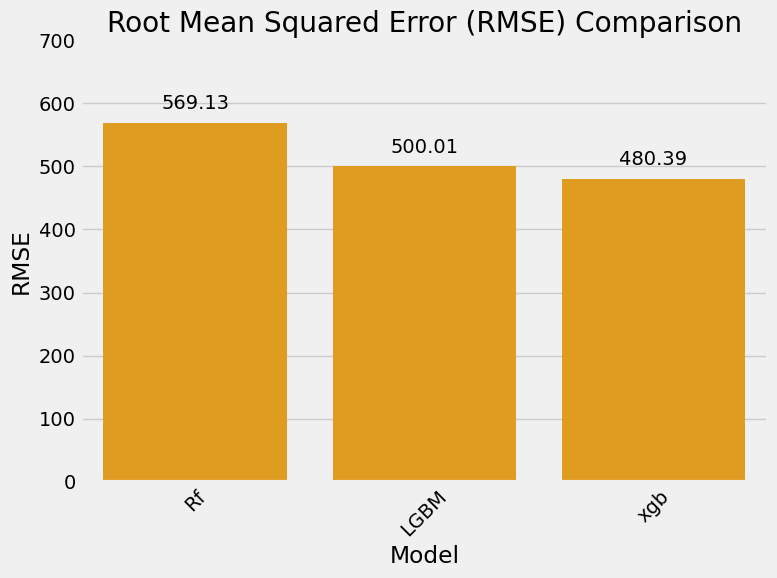

In [273]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Model_name', y='RMSE', data=error_df, color='orange')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.ylim(0, 700)

 

for index, row in error_df.iterrows():
    plt.annotate(f'{row["RMSE"]:.2f}', (index, row['RMSE']), textcoords="offset points", xytext=(0,10), ha='center')

 

plt.xticks(rotation=45)
plt.tight_layout()

 

plt.show()

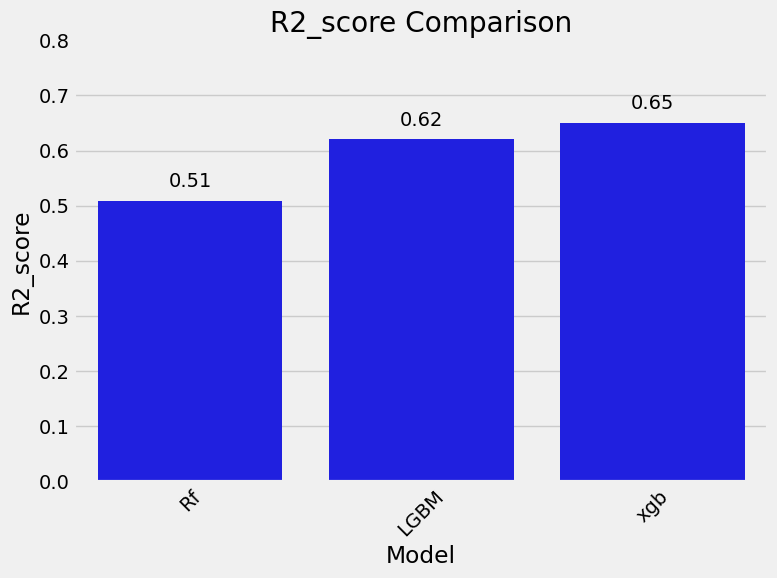

In [271]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Model_name', y='R2_score', data=error_df, color='blue')
plt.xlabel('Model')
plt.ylabel('R2_score')
plt.title('R2_score Comparison')
plt.ylim(0 , 0.8)

 

for index, row in error_df.iterrows():
    plt.annotate(f'{row["R2_score"]:.2f}', (index, row['R2_score']), textcoords="offset points", xytext=(0,10), ha='center')

 

plt.xticks(rotation=45)
plt.tight_layout()

 

plt.show()

#### When we examine the error and r2 scores, we realize that the algorithm that works best is XGBRegressor

In [264]:
xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=500,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=4,
                       learning_rate=0.01)
xgb_reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[17:10:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1430.97211	validation_1-rmse:1329.73285
[100]	validation_0-rmse:610.69427	validation_1-rmse:694.08392
[200]	validation_0-rmse:357.94388	validation_1-rmse:518.07495
[300]	validation_0-rmse:293.93015	validation_1-rmse:480.55077
[353]	validation_0-rmse:280.42116	validation_1-rmse:482.59908


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [265]:
y_pred = xgb_reg.predict(X_test)

In [266]:
model_results(Y_test, y_pred,'xgb')

MSE score of model is 230777.89435416012
RMSE score of model is 480.3934786757207
MAE score of model is 280.9247784868807


,Model_name,MAE,RMSE,R2_score
0,xgb,280.924778,480.393479,0.649603


## Feature Iportance for Best model ML (XGBRegressor)

In [267]:
feature_importance= pd.DataFrame(data   = xgb_reg.feature_importances_,
                 index  = xgb_reg.feature_names_in_,
                 columns= ['importance'])
feature_importance_25 = feature_importance.sort_values('importance', ascending=False).head(25)

In [268]:
feature_importance_25

,importance
lag_7,0.349485
lag_1,0.263011
dayofweek_0,0.045177
dayofweek_4,0.025275
dayofweek_5,0.022529
month_4,0.022213
lag_91,0.020511
lag_182,0.019640
dayofweek_1,0.018958
year_2023,0.018731


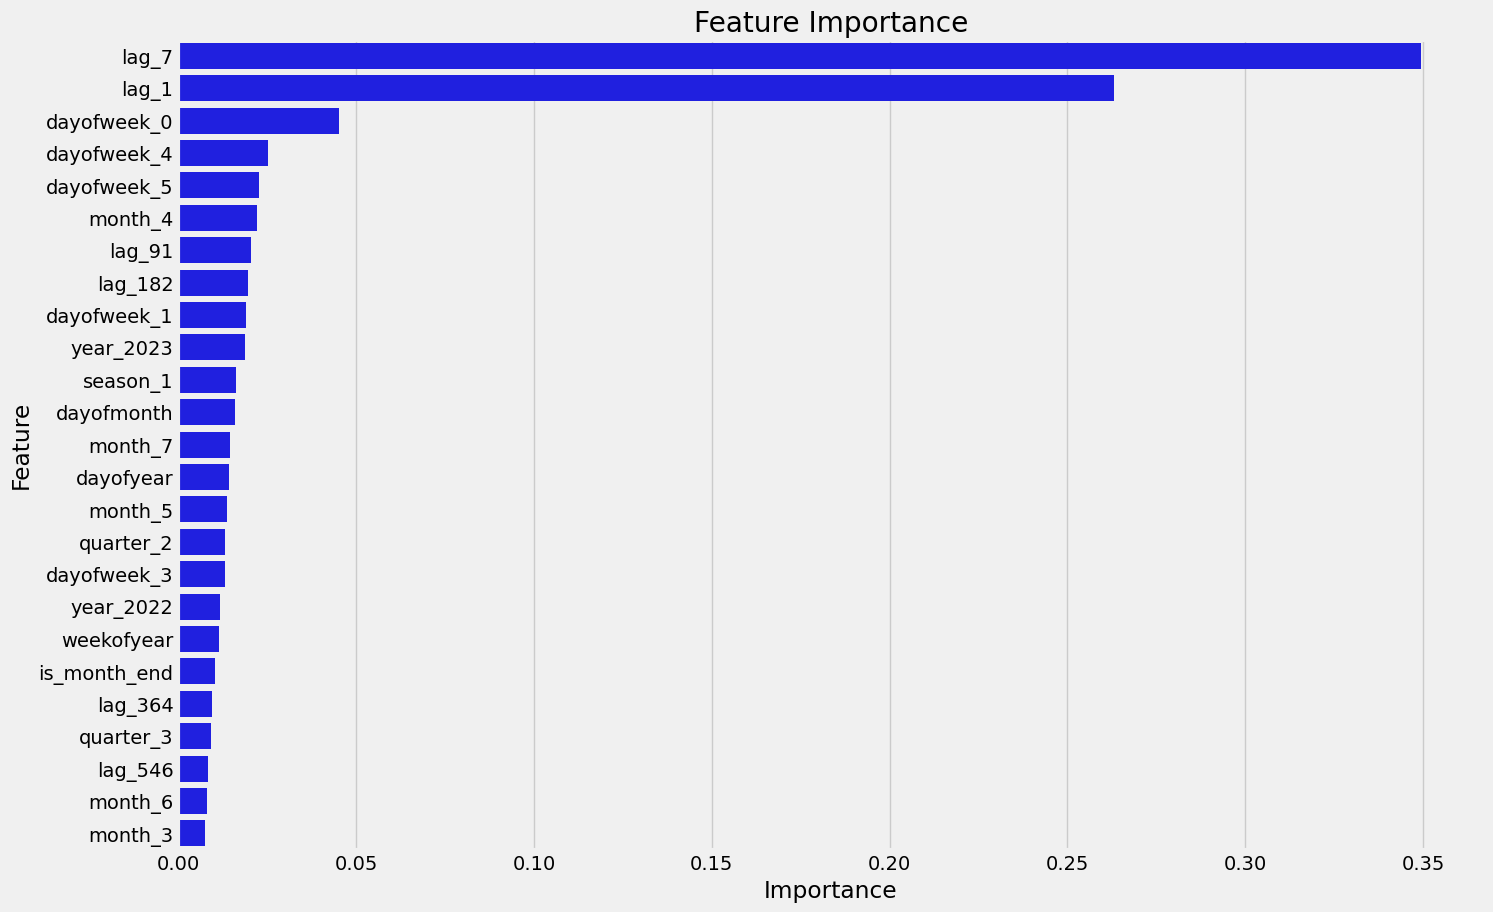

In [269]:

plt.figure(figsize=(15, 10))

sorted_data = feature_importance_25.sort_values('importance', ascending=False)

sns.barplot(x='importance', y=sorted_data.index, data=sorted_data, color='blue')

plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()